In [1]:
# Cell 1: Imports and Setup
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.models import ResNet18_Weights
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.metrics import (confusion_matrix, classification_report,
                           roc_curve, auc, precision_recall_curve,
                           accuracy_score, precision_score, recall_score,
                           f1_score, matthews_corrcoef)
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from PIL import Image
import glob
from datetime import datetime
import json
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("✅ All imports successful and device configured")

Using device: cuda
✅ All imports successful and device configured


In [2]:
# Cell 2: Custom Dataset Class
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform

        # Define class names based on your folder structure
        self.classes = ['NO-PREPROCESSED', 'YES-PREPROCESSED']
        self.class_to_idx = {self.classes[0]: 0, self.classes[1]: 1}

        # Get all image paths
        self.image_paths = []
        self.labels = []

        print(f"Looking for data in: {root_dir}")

        for class_idx, class_name in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_name)
            print(f"Checking directory: {class_path}")

            if os.path.isdir(class_path):
                # Get all image files
                image_files = []
                for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']:
                    files = glob.glob(os.path.join(class_path, ext))
                    image_files.extend(files)

                print(f"Found {len(image_files)} images in {class_name} class")
                self.image_paths.extend(image_files)
                self.labels.extend([class_idx] * len(image_files))
            else:
                print(f"Directory {class_path} does not exist")

        print(f"Total images found: {len(self.image_paths)}")
        print(f"Label distribution: No tumor: {self.labels.count(0)}, Tumor: {self.labels.count(1)}")

        if len(self.image_paths) == 0:
            raise ValueError("No images found! Please check your directory structure.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if idx >= len(self.image_paths):
            raise IndexError(f"Index {idx} out of range for dataset of size {len(self.image_paths)}")

        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            image = Image.new('RGB', (224, 224), color='black')

        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label, img_path

print("✅ Dataset class defined successfully")

✅ Dataset class defined successfully


In [3]:
# Cell 3: Data Preparation and Transforms
dataset_path = "/content/drive/MyDrive/DATASETS/Preprocessed-Datasets/preproccessed"

# Data transforms
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
print("=== Loading Dataset ===")
full_dataset_train = BrainTumorDataset(root_dir=dataset_path, transform=transform_train)
full_dataset_test = BrainTumorDataset(root_dir=dataset_path, transform=transform_test)

# Split into train and test
train_size = int(0.8 * len(full_dataset_train))
test_size = len(full_dataset_train) - train_size

indices = list(range(len(full_dataset_train)))
np.random.shuffle(indices)

train_indices = indices[:train_size]
test_indices = indices[train_size:]

# Create subset datasets
train_dataset = torch.utils.data.Subset(full_dataset_train, train_indices)
test_dataset = torch.utils.data.Subset(full_dataset_test, test_indices)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print("✅ Data loaders created successfully")

=== Loading Dataset ===
Looking for data in: /content/drive/MyDrive/DATASETS/Preprocessed-Datasets/preproccessed
Checking directory: /content/drive/MyDrive/DATASETS/Preprocessed-Datasets/preproccessed/NO-PREPROCESSED
Found 183 images in NO-PREPROCESSED class
Checking directory: /content/drive/MyDrive/DATASETS/Preprocessed-Datasets/preproccessed/YES-PREPROCESSED
Found 308 images in YES-PREPROCESSED class
Total images found: 491
Label distribution: No tumor: 183, Tumor: 308
Looking for data in: /content/drive/MyDrive/DATASETS/Preprocessed-Datasets/preproccessed
Checking directory: /content/drive/MyDrive/DATASETS/Preprocessed-Datasets/preproccessed/NO-PREPROCESSED
Found 183 images in NO-PREPROCESSED class
Checking directory: /content/drive/MyDrive/DATASETS/Preprocessed-Datasets/preproccessed/YES-PREPROCESSED
Found 308 images in YES-PREPROCESSED class
Total images found: 491
Label distribution: No tumor: 183, Tumor: 308
Train dataset size: 392
Test dataset size: 99
✅ Data loaders created s

In [4]:
# Cell 4: Model Architecture
class BrainTumorClassifier(nn.Module):
    def __init__(self, pretrained=True):
        super(BrainTumorClassifier, self).__init__()

        # Use ResNet18 as backbone
        self.backbone = models.resnet18(weights=ResNet18_Weights.DEFAULT if pretrained else None)

        # Replace the final layer for binary classification
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1)
        )

        # Store layer names for GradCAM
        self.layer_names = ['backbone.layer1', 'backbone.layer2', 'backbone.layer3', 'backbone.layer4']

    def forward(self, x):
        return self.backbone(x)

# Create model
model = BrainTumorClassifier(pretrained=True)
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model created successfully")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

print("✅ Model architecture defined successfully")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 143MB/s]


Model created successfully
Total parameters: 11,570,753
Trainable parameters: 11,570,753
✅ Model architecture defined successfully


In [5]:
# Cell 5: Training Loop
print("=== Starting Training ===")

num_epochs = 20
best_val_loss = float('inf')
best_model_state = None

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch_idx, (images, labels, _) in enumerate(train_loader):
        images, labels = images.to(device), labels.float().to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        predicted = (torch.sigmoid(outputs) >= 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels, _ in test_loader:
            images, labels = images.to(device), labels.float().to(device).unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate accuracy
            predicted = (torch.sigmoid(outputs) >= 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(test_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # Learning rate scheduling
    scheduler.step(avg_val_loss)

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict().copy()

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%")
    print(f"  Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
    print(f"  LR: {optimizer.param_groups[0]['lr']:.6f}")
    print("-" * 50)

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"✅ Loaded best model with validation loss: {best_val_loss:.4f}")

print("✅ Training completed successfully")

=== Starting Training ===
Epoch 1/20
  Train Loss: 0.5829, Train Acc: 67.35%
  Val Loss: 0.4686, Val Acc: 89.90%
  LR: 0.000100
--------------------------------------------------
Epoch 2/20
  Train Loss: 0.3254, Train Acc: 90.05%
  Val Loss: 0.1809, Val Acc: 93.94%
  LR: 0.000100
--------------------------------------------------
Epoch 3/20
  Train Loss: 0.2015, Train Acc: 93.62%
  Val Loss: 0.1799, Val Acc: 90.91%
  LR: 0.000100
--------------------------------------------------
Epoch 4/20
  Train Loss: 0.0561, Train Acc: 98.72%
  Val Loss: 0.1017, Val Acc: 96.97%
  LR: 0.000100
--------------------------------------------------
Epoch 5/20
  Train Loss: 0.0496, Train Acc: 98.47%
  Val Loss: 0.1183, Val Acc: 97.98%
  LR: 0.000100
--------------------------------------------------
Epoch 6/20
  Train Loss: 0.0904, Train Acc: 95.66%
  Val Loss: 0.2988, Val Acc: 90.91%
  LR: 0.000100
--------------------------------------------------
Epoch 7/20
  Train Loss: 0.0474, Train Acc: 98.72%
  Val

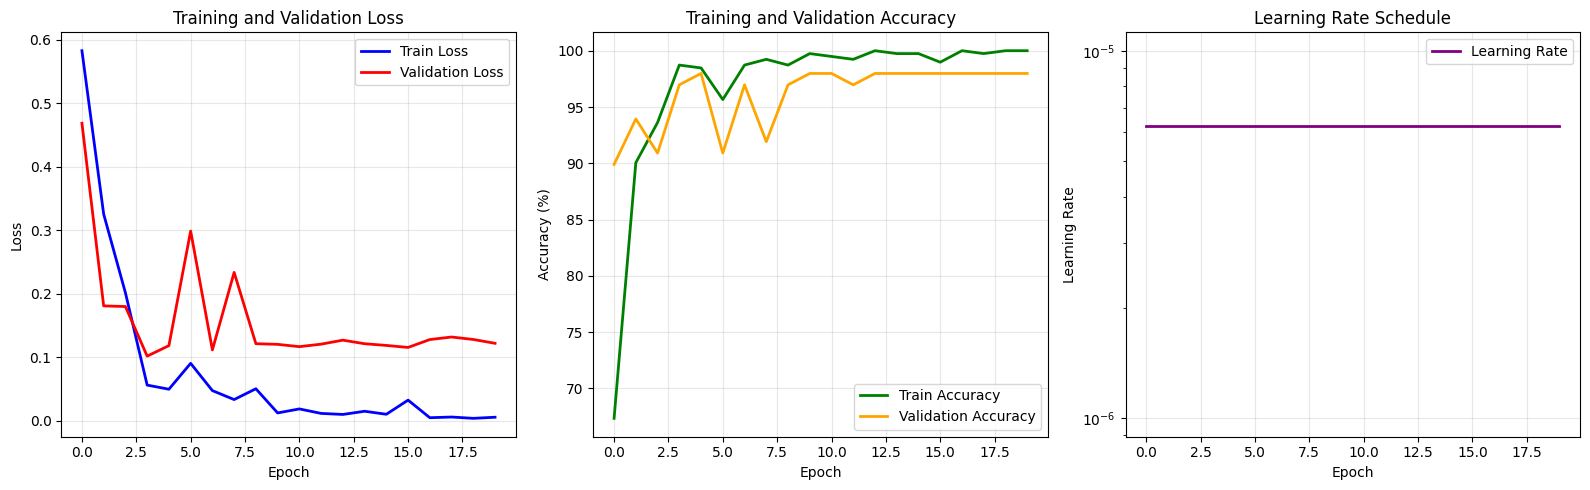

✅ Training visualization complete


In [6]:
# Cell 6: Training History Visualization
plt.figure(figsize=(16, 5))

# Plot training history
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss', color='blue', linewidth=2)
plt.plot(val_losses, label='Validation Loss', color='red', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='green', linewidth=2)
plt.plot(val_accuracies, label='Validation Accuracy', color='orange', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(optimizer.param_groups[0]['lr'] * np.ones(len(train_losses)),
         label='Learning Rate', color='purple', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

plt.tight_layout()
plt.show()

print("✅ Training visualization complete")

In [7]:
# Cell 7: GradCAM Implementation
class GradCAM:
    def __init__(self, model, target_layer_name='backbone.layer4'):
        self.model = model
        self.target_layer_name = target_layer_name
        self.gradients = None
        self.activations = None
        self.hooks = []

        # Register hooks
        self.register_hooks()

    def register_hooks(self):
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        def forward_hook(module, input, output):
            self.activations = output

        # Get the target layer
        target_layer = dict([*self.model.named_modules()])[self.target_layer_name]

        # Register hooks
        hook1 = target_layer.register_backward_hook(backward_hook)
        hook2 = target_layer.register_forward_hook(forward_hook)

        self.hooks = [hook1, hook2]

    def generate_cam(self, input_image, class_idx=None):
        # Forward pass
        self.model.eval()
        model_output = self.model(input_image)

        if class_idx is None:
            class_idx = torch.sigmoid(model_output).item() >= 0.5

        # Backward pass
        self.model.zero_grad()
        model_output[0][0].backward(retain_graph=True)

        # Generate CAM
        if self.gradients is None or self.activations is None:
            return np.zeros((224, 224))

        gradients = self.gradients[0].cpu().data.numpy()
        activations = self.activations[0].cpu().data.numpy()

        # Calculate weights
        weights = np.mean(gradients, axis=(1, 2))

        # Generate weighted combination
        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * activations[i]

        # Apply ReLU
        cam = np.maximum(cam, 0)

        # Resize to input size
        cam = cv2.resize(cam, (224, 224))

        # Normalize
        if cam.max() > 0:
            cam = cam / cam.max()

        return cam

    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()

# Helper function to denormalize images
def denormalize_image(tensor):
    """Denormalize image tensor for display"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    denormalized = tensor * std + mean
    denormalized = torch.clamp(denormalized, 0, 1)

    return denormalized.permute(1, 2, 0).numpy()

print("✅ GradCAM implementation complete")

✅ GradCAM implementation complete


In [8]:
# Cell 8: Comprehensive Model Evaluation
def evaluate_model_comprehensive(model, data_loader):
    """Comprehensive model evaluation with all metrics"""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    all_paths = []

    with torch.no_grad():
        for images, labels, paths in data_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            probs = torch.sigmoid(outputs).squeeze()

            # Handle single sample case
            if probs.dim() == 0:
                probs = probs.unsqueeze(0)

            probs_np = probs.cpu().numpy()
            preds = (probs_np >= 0.5).astype(int)

            all_probs.extend(probs_np)
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
            all_paths.extend(paths)

    return np.array(all_labels), np.array(all_preds), np.array(all_probs), all_paths

def calculate_all_metrics(y_true, y_pred, y_prob):
    """Calculate all classification metrics"""
    metrics = {}

    # Basic metrics
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['precision'] = precision_score(y_true, y_pred, zero_division=0)
    metrics['recall'] = recall_score(y_true, y_pred, zero_division=0)
    metrics['f1'] = f1_score(y_true, y_pred, zero_division=0)
    metrics['mcc'] = matthews_corrcoef(y_true, y_pred)

    # Confusion matrix derived metrics
    cm = confusion_matrix(y_true, y_pred)
    if cm.size == 4:
        tn, fp, fn, tp = cm.ravel()
        metrics['sensitivity'] = tp / (tp + fn) if (tp + fn) > 0 else 0
        metrics['specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0
        metrics['npv'] = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value
        metrics['ppv'] = tp / (tp + fp) if (tp + fp) > 0 else 0  # Positive Predictive Value

    # ROC AUC
    if len(np.unique(y_true)) > 1:
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        metrics['auc_roc'] = auc(fpr, tpr)

        # Precision-Recall AUC
        precision, recall, _ = precision_recall_curve(y_true, y_prob)
        metrics['auc_pr'] = auc(recall, precision)
    else:
        metrics['auc_roc'] = 0.5
        metrics['auc_pr'] = 0.5

    return metrics, cm

# Evaluate the model
print("=== Comprehensive Model Evaluation ===")
y_true, y_pred, y_prob, image_paths = evaluate_model_comprehensive(model, test_loader)

# Calculate all metrics
metrics, cm = calculate_all_metrics(y_true, y_pred, y_prob)

print(f"Test samples: {len(y_true)}")
print(f"Predictions distribution: No tumor: {np.sum(y_pred == 0)}, Tumor: {np.sum(y_pred == 1)}")
print(f"True labels distribution: No tumor: {np.sum(y_true == 0)}, Tumor: {np.sum(y_true == 1)}")

# Display metrics
print("\n=== DETAILED METRICS ===")
print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall/Sensitivity: {metrics['recall']:.4f}")
print(f"Specificity: {metrics['specificity']:.4f}")
print(f"F1-Score: {metrics['f1']:.4f}")
print(f"Matthews Correlation Coefficient: {metrics['mcc']:.4f}")
print(f"ROC AUC: {metrics['auc_roc']:.4f}")
print(f"Precision-Recall AUC: {metrics['auc_pr']:.4f}")
print(f"Positive Predictive Value: {metrics['ppv']:.4f}")
print(f"Negative Predictive Value: {metrics['npv']:.4f}")

print("✅ Comprehensive evaluation complete")

=== Comprehensive Model Evaluation ===
Test samples: 99
Predictions distribution: No tumor: 34, Tumor: 65
True labels distribution: No tumor: 32, Tumor: 67

=== DETAILED METRICS ===
Accuracy: 0.9798
Precision: 1.0000
Recall/Sensitivity: 0.9701
Specificity: 1.0000
F1-Score: 0.9848
Matthews Correlation Coefficient: 0.9556
ROC AUC: 0.9991
Precision-Recall AUC: 0.9996
Positive Predictive Value: 1.0000
Negative Predictive Value: 0.9412
✅ Comprehensive evaluation complete


In [9]:
# Cell 9: Visualization Functions
def plot_confusion_matrix(y_true, y_pred, classes=['No Tumor', 'Tumor']):
    """Plot confusion matrix with detailed metrics"""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))

    # Plot confusion matrix
    plt.subplot(2, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes,
                cbar_kws={'label': 'Count'})
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

    # Plot normalized confusion matrix
    plt.subplot(2, 2, 2)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=classes, yticklabels=classes,
                cbar_kws={'label': 'Proportion'})
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Normalized Confusion Matrix')

    # Plot metrics text
    plt.subplot(2, 2, 3)
    plt.axis('off')

    if cm.size == 4:
        tn, fp, fn, tp = cm.ravel()
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        metrics_text = f"""
        Detailed Metrics:

        True Positives: {tp}
        True Negatives: {tn}
        False Positives: {fp}
        False Negatives: {fn}

        Accuracy: {accuracy:.4f}
        Precision: {precision:.4f}
        Recall: {recall:.4f}
        Specificity: {specificity:.4f}
        F1-Score: {f1:.4f}
        """

        plt.text(0.1, 0.5, metrics_text, fontsize=12, verticalalignment='center',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

    plt.tight_layout()
    plt.show()

    return cm

def plot_roc_and_pr_curves(y_true, y_prob):
    """Plot ROC and Precision-Recall curves"""
    if len(np.unique(y_true)) < 2:
        print("Cannot plot curves: only one class present")
        return

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    # Calculate Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(15, 5))

    # ROC Curve
    plt.subplot(1, 3, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)

    # Precision-Recall Curve
    plt.subplot(1, 3, 2)
    plt.plot(recall, precision, color='green', lw=2,
             label=f'PR curve (AUC = {pr_auc:.4f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.grid(True, alpha=0.3)

    # Threshold analysis
    plt.subplot(1, 3, 3)
    thresholds = np.linspace(0, 1, 100)
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in thresholds:
        y_pred_thresh = (y_prob >= threshold).astype(int)
        if len(np.unique(y_pred_thresh)) > 1:
            p = precision_score(y_true, y_pred_thresh, zero_division=0)
            r = recall_score(y_true, y_pred_thresh, zero_division=0)
            f1 = f1_score(y_true, y_pred_thresh, zero_division=0)
        else:
            p = r = f1 = 0
        precisions.append(p)
        recalls.append(r)
        f1_scores.append(f1)

    plt.plot(thresholds, precisions, label='Precision', color='blue')
    plt.plot(thresholds, recalls, label='Recall', color='red')
    plt.plot(thresholds, f1_scores, label='F1-Score', color='green')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Threshold Analysis')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return roc_auc, pr_auc

def visualize_predictions_with_heatmap(model, data_loader, num_samples=8):
    """Visualize predictions with GradCAM heatmaps"""
    model.eval()
    gradcam = GradCAM(model, target_layer_name='backbone.layer4')

    fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    sample_count = 0

    for images, labels, paths in data_loader:
        for i in range(len(images)):
            if sample_count >= num_samples:
                break

            image = images[i:i+1].to(device)
            label = labels[i].item()

            # Get prediction
            with torch.no_grad():
                output = model(image)
                prob = torch.sigmoid(output).item()
                pred = 1 if prob >= 0.5 else 0

            # Generate GradCAM
            cam = gradcam.generate_cam(image)

            # Denormalize image for display
            img_display = denormalize_image(images[i])

            # Plot original image
            axes[sample_count, 0].imshow(img_display)
            axes[sample_count, 0].set_title(f'Original\nTrue: {"Tumor" if label == 1 else "No Tumor"}')
            axes[sample_count, 0].axis('off')

            # Plot GradCAM heatmap
            axes[sample_count, 1].imshow(cam, cmap='jet')
            axes[sample_count, 1].set_title(f'GradCAM Heatmap\nFocus Areas')
            axes[sample_count, 1].axis('off')

            # Plot overlay
            axes[sample_count, 2].imshow(img_display)
            axes[sample_count, 2].imshow(cam, cmap='jet', alpha=0.4)
            axes[sample_count, 2].set_title(f'Overlay\nPred: {"Tumor" if pred == 1 else "No Tumor"}')
            axes[sample_count, 2].axis('off')

            # Plot prediction details
            axes[sample_count, 3].axis('off')
            color = 'green' if pred == label else 'red'
            status = '✓ Correct' if pred == label else '✗ Incorrect'

            pred_text = f"""
            Prediction Details:

            Confidence: {prob:.3f}
            Predicted: {"Tumor" if pred == 1 else "No Tumor"}
            Actual: {"Tumor" if label == 1 else "No Tumor"}

            Status: {status}

            Image: {os.path.basename(paths[i])}
            """

            axes[sample_count, 3].text(0.1, 0.5, pred_text, fontsize=11,
                                     verticalalignment='center',
                                     bbox=dict(boxstyle='round', facecolor=color, alpha=0.2))

            sample_count += 1

        if sample_count >= num_samples:
            break

    plt.tight_layout()
    plt.show()

    # Clean up
    gradcam.remove_hooks()

print("✅ Visualization functions defined")

✅ Visualization functions defined


=== Generating All Visualizations ===
1. Generating Confusion Matrix...


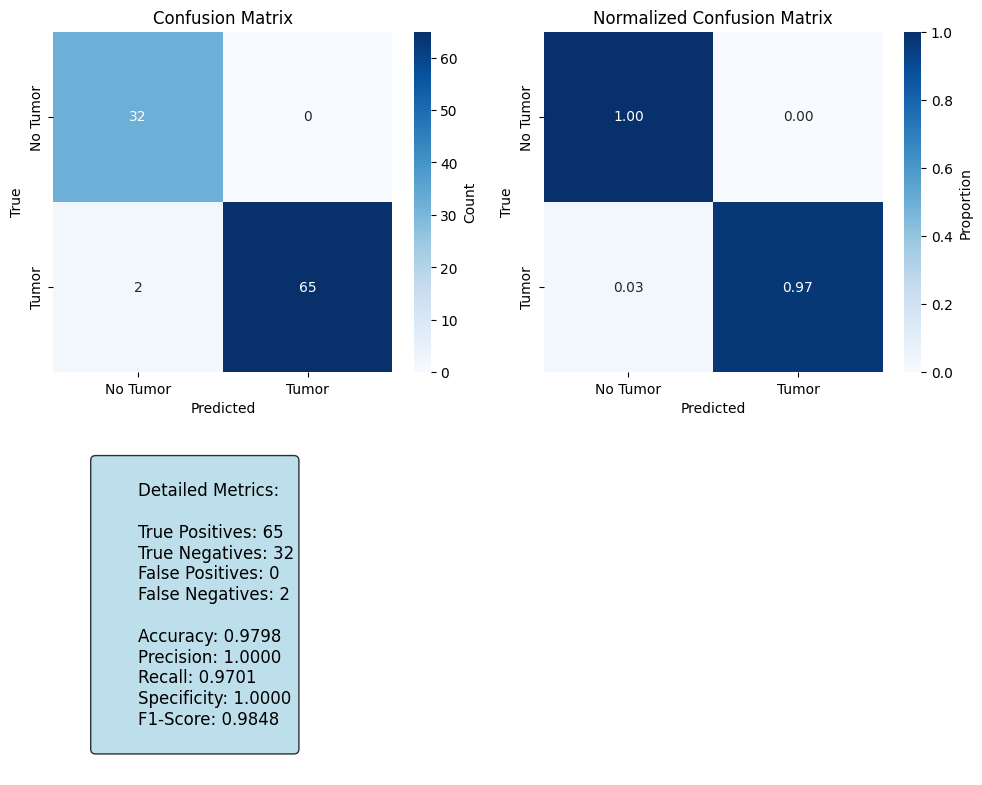

2. Generating ROC and Precision-Recall Curves...


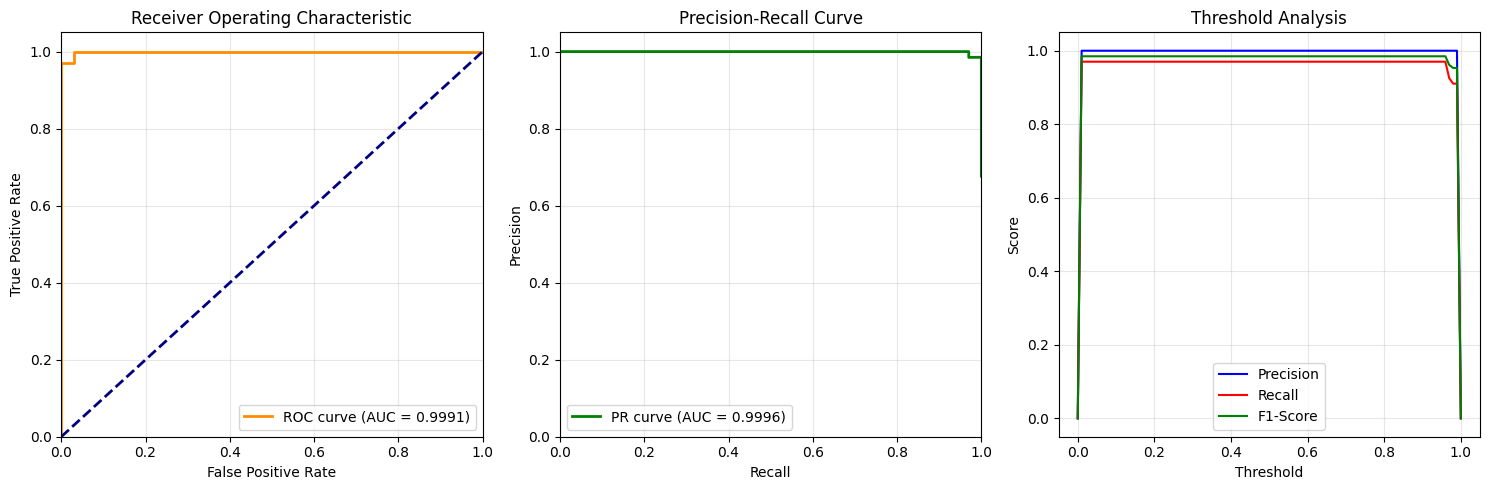

3. Generating Predictions with GradCAM Heatmaps...


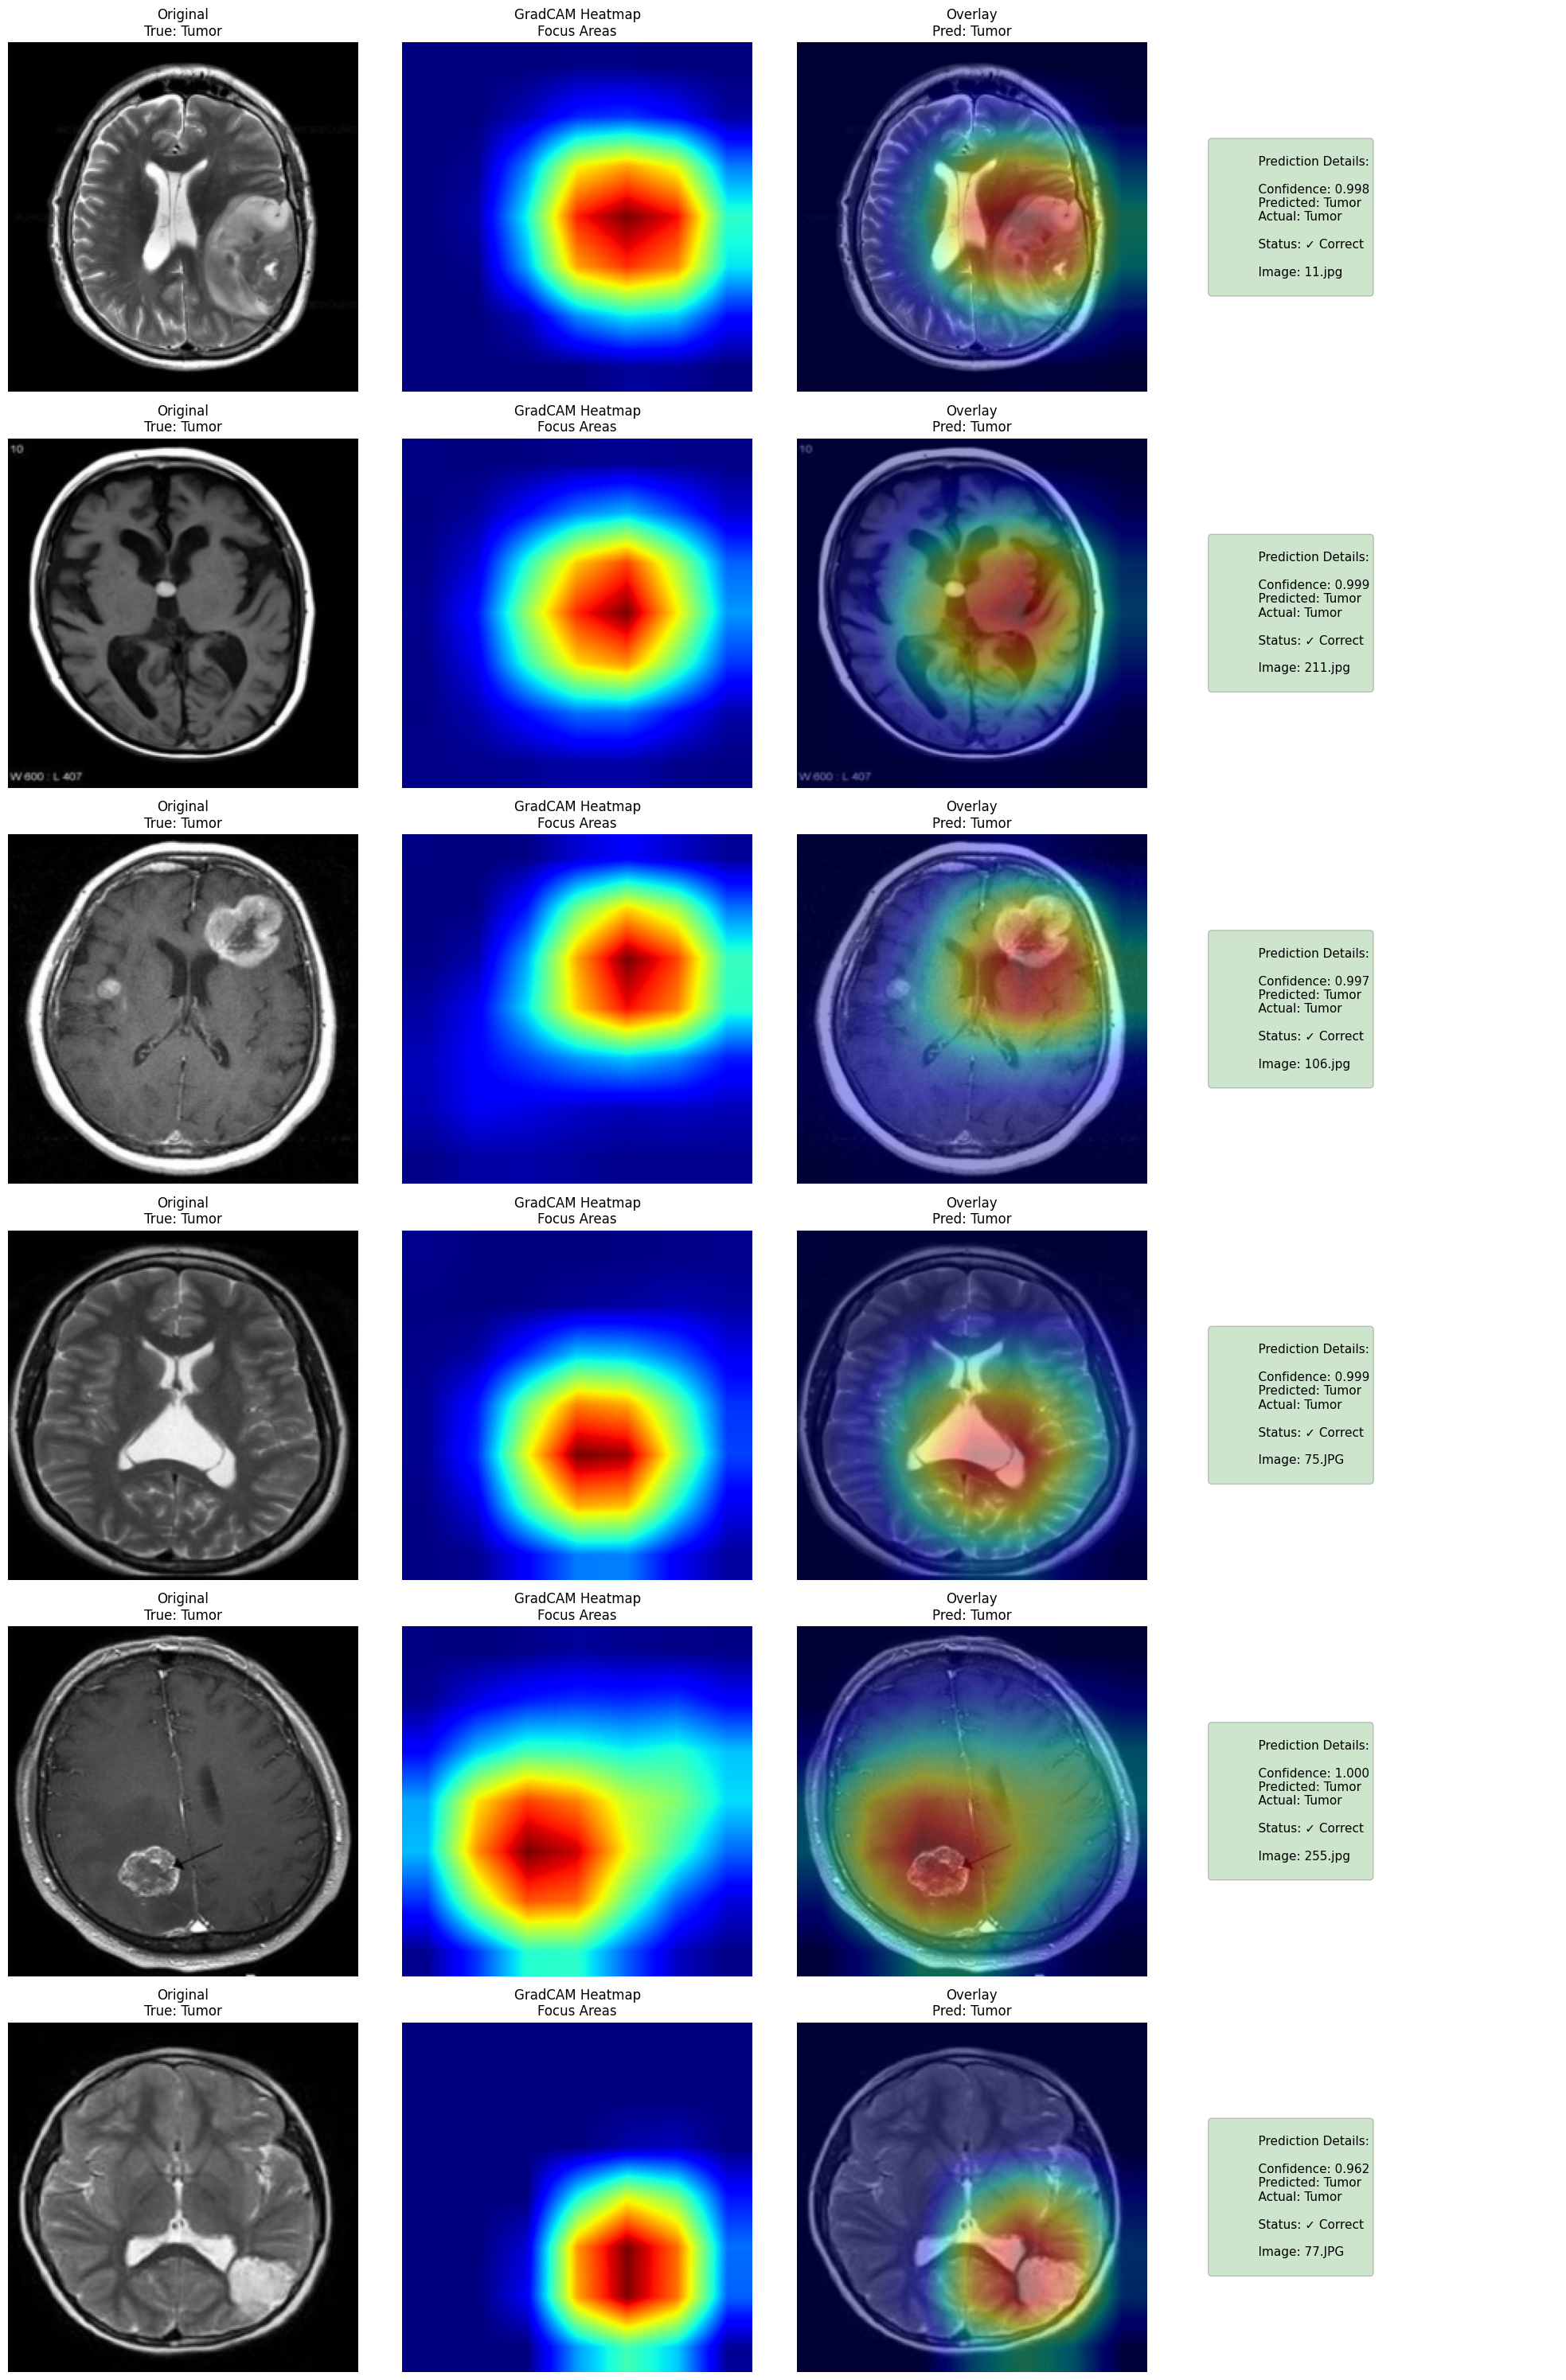

4. Generating Classification Report...

CLASSIFICATION REPORT
              precision    recall  f1-score   support

    No Tumor       0.94      1.00      0.97        32
       Tumor       1.00      0.97      0.98        67

    accuracy                           0.98        99
   macro avg       0.97      0.99      0.98        99
weighted avg       0.98      0.98      0.98        99

5. Performing Error Analysis...

Error Analysis:
Total incorrect predictions: 2
False Positives: 0
False Negatives: 2


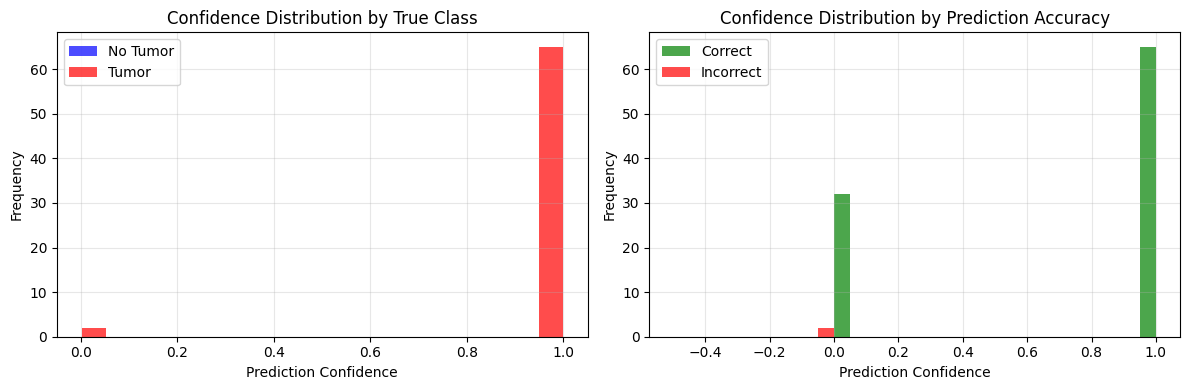

✅ All visualizations generated successfully


In [10]:
# Cell 10: Generate All Visualizations
print("=== Generating All Visualizations ===")

# 1. Confusion Matrix
print("1. Generating Confusion Matrix...")
cm = plot_confusion_matrix(y_true, y_pred)

# 2. ROC and PR Curves
print("2. Generating ROC and Precision-Recall Curves...")
roc_auc, pr_auc = plot_roc_and_pr_curves(y_true, y_prob)

# 3. Predictions with Heatmaps
print("3. Generating Predictions with GradCAM Heatmaps...")
visualize_predictions_with_heatmap(model, test_loader, num_samples=6)

# 4. Classification Report
print("4. Generating Classification Report...")
print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_true, y_pred, target_names=['No Tumor', 'Tumor'], zero_division=0))

# 5. Error Analysis
print("5. Performing Error Analysis...")
incorrect_indices = np.where(y_true != y_pred)[0]
print(f"\nError Analysis:")
print(f"Total incorrect predictions: {len(incorrect_indices)}")
print(f"False Positives: {np.sum((y_true == 0) & (y_pred == 1))}")
print(f"False Negatives: {np.sum((y_true == 1) & (y_pred == 0))}")

# 6. Confidence Distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(y_prob[y_true == 0], bins=20, alpha=0.7, label='No Tumor', color='blue')
plt.hist(y_prob[y_true == 1], bins=20, alpha=0.7, label='Tumor', color='red')
plt.xlabel('Prediction Confidence')
plt.ylabel('Frequency')
plt.title('Confidence Distribution by True Class')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
correct_mask = y_true == y_pred
plt.hist(y_prob[correct_mask], bins=20, alpha=0.7, label='Correct', color='green')
plt.hist(y_prob[~correct_mask], bins=20, alpha=0.7, label='Incorrect', color='red')
plt.xlabel('Prediction Confidence')
plt.ylabel('Frequency')
plt.title('Confidence Distribution by Prediction Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ All visualizations generated successfully")

In [11]:
# Cell 11: Enhanced Model Saving with Complete Information
print("=== Saving Enhanced Model ===")

# Create comprehensive report
training_report = {
    'model_info': {
        'model_name': 'BrainTumorClassifier',
        'architecture': 'ResNet18-based',
        'total_parameters': sum(p.numel() for p in model.parameters()),
        'trainable_parameters': sum(p.numel() for p in model.parameters() if p.requires_grad),
        'input_size': (224, 224),
        'num_classes': 2,
        'class_names': ['NO-PREPROCESSED', 'YES-PREPROCESSED']
    },
    'training_info': {
        'epochs': num_epochs,
        'batch_size': batch_size,
        'learning_rate': 0.0001,
        'optimizer': 'Adam',
        'loss_function': 'BCEWithLogitsLoss',
        'scheduler': 'ReduceLROnPlateau',
        'best_val_loss': float(best_val_loss),
        'final_train_loss': float(train_losses[-1]),
        'final_val_loss': float(val_losses[-1]),
        'final_train_acc': float(train_accuracies[-1]),
        'final_val_acc': float(val_accuracies[-1])
    },
    'dataset_info': {
        'total_samples': len(full_dataset_train),
        'train_samples': len(train_dataset),
        'test_samples': len(test_dataset),
        'train_split': 0.8,
        'test_split': 0.2,
        'no_tumor_samples': full_dataset_train.labels.count(0),
        'tumor_samples': full_dataset_train.labels.count(1)
    },
    'evaluation_metrics': {
        'test_accuracy': float(metrics['accuracy']),
        'test_precision': float(metrics['precision']),
        'test_recall': float(metrics['recall']),
        'test_f1_score': float(metrics['f1']),
        'test_specificity': float(metrics['specificity']),
        'test_sensitivity': float(metrics['sensitivity']),
        'test_auc_roc': float(metrics['auc_roc']),
        'test_auc_pr': float(metrics['auc_pr']),
        'test_mcc': float(metrics['mcc']),
        'test_ppv': float(metrics['ppv']),
        'test_npv': float(metrics['npv'])
    },
    'training_history': {
        'train_losses': [float(x) for x in train_losses],
        'val_losses': [float(x) for x in val_losses],
        'train_accuracies': [float(x) for x in train_accuracies],
        'val_accuracies': [float(x) for x in val_accuracies]
    },
    'test_results': {
        'y_true': y_true.tolist(),
        'y_pred': y_pred.tolist(),
        'y_prob': y_prob.tolist(),
        'image_paths': image_paths,
        'confusion_matrix': cm.tolist()
    },
    'timestamp': datetime.now().isoformat(),
    'device': str(device)
}

# Save model with complete information
model_save_path = 'brain_tumor_detection_model_complete.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'training_report': training_report,
    'model_class': 'BrainTumorClassifier',
    'version': '2.0'
}, model_save_path)

# Save training report as JSON
report_path = 'brain_tumor_training_report.json'
with open(report_path, 'w') as f:
    json.dump(training_report, f, indent=2)

print(f"✅ Enhanced model saved to: {model_save_path}")
print(f"✅ Training report saved to: {report_path}")

# Display summary
print("\n" + "="*60)
print("🎉 TRAINING COMPLETE - SUMMARY REPORT")
print("="*60)
print(f"📊 Dataset: {training_report['dataset_info']['total_samples']} images")
print(f"   - No Tumor: {training_report['dataset_info']['no_tumor_samples']}")
print(f"   - Tumor: {training_report['dataset_info']['tumor_samples']}")
print(f"🏋️ Training: {training_report['training_info']['epochs']} epochs")
print(f"   - Best Val Loss: {training_report['training_info']['best_val_loss']:.4f}")
print(f"   - Final Train Acc: {training_report['training_info']['final_train_acc']:.2f}%")
print(f"   - Final Val Acc: {training_report['training_info']['final_val_acc']:.2f}%")
print(f"🎯 Test Performance:")
print(f"   - Accuracy: {training_report['evaluation_metrics']['test_accuracy']:.4f}")
print(f"   - Precision: {training_report['evaluation_metrics']['test_precision']:.4f}")
print(f"   - Recall: {training_report['evaluation_metrics']['test_recall']:.4f}")
print(f"   - F1-Score: {training_report['evaluation_metrics']['test_f1_score']:.4f}")
print(f"   - ROC AUC: {training_report['evaluation_metrics']['test_auc_roc']:.4f}")
print(f"   - Specificity: {training_report['evaluation_metrics']['test_specificity']:.4f}")
print(f"💾 Model saved with complete training history and heatmap capability")
print("="*60)

=== Saving Enhanced Model ===
✅ Enhanced model saved to: brain_tumor_detection_model_complete.pth
✅ Training report saved to: brain_tumor_training_report.json

🎉 TRAINING COMPLETE - SUMMARY REPORT
📊 Dataset: 491 images
   - No Tumor: 183
   - Tumor: 308
🏋️ Training: 20 epochs
   - Best Val Loss: 0.1017
   - Final Train Acc: 100.00%
   - Final Val Acc: 97.98%
🎯 Test Performance:
   - Accuracy: 0.9798
   - Precision: 1.0000
   - Recall: 0.9701
   - F1-Score: 0.9848
   - ROC AUC: 0.9991
   - Specificity: 1.0000
💾 Model saved with complete training history and heatmap capability


In [12]:
# Cell 12: Model Loading and Inference Functions
def load_trained_model(model_path):
    """Load the saved model with all information"""
    print(f"Loading model from: {model_path}")

    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=device)

    # Create model architecture
    model = BrainTumorClassifier()
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()

    # Extract training report
    training_report = checkpoint['training_report']

    print("✅ Model loaded successfully!")
    print(f"   - Model version: {checkpoint.get('version', '1.0')}")
    print(f"   - Training date: {training_report['timestamp']}")
    print(f"   - Test accuracy: {training_report['evaluation_metrics']['test_accuracy']:.4f}")
    print(f"   - Test AUC: {training_report['evaluation_metrics']['test_auc_roc']:.4f}")

    return model, training_report

def predict_single_image(model, image_path, transform=None):
    """Predict on a single image with heatmap generation"""
    if transform is None:
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    # Load and preprocess image
    try:
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image).unsqueeze(0).to(device)
    except Exception as e:
        print(f"Error loading image: {e}")
        return None

    # Make prediction
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        probability = torch.sigmoid(output).item()
        prediction = 1 if probability >= 0.5 else 0

    # Generate heatmap
    gradcam = GradCAM(model, target_layer_name='backbone.layer4')
    heatmap = gradcam.generate_cam(image_tensor)
    gradcam.remove_hooks()

    # Prepare original image for display
    img_display = np.array(image.resize((224, 224)))

    # Create visualization
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    # Original image
    axes[0].imshow(img_display)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Heatmap
    axes[1].imshow(heatmap, cmap='jet')
    axes[1].set_title('GradCAM Heatmap')
    axes[1].axis('off')

    # Overlay
    axes[2].imshow(img_display)
    axes[2].imshow(heatmap, cmap='jet', alpha=0.4)
    axes[2].set_title('Overlay')
    axes[2].axis('off')

    # Prediction details
    axes[3].axis('off')
    color = 'red' if prediction == 1 else 'green'
    result_text = f"""
    PREDICTION RESULTS

    Probability: {probability:.4f}
    Prediction: {"TUMOR DETECTED" if prediction == 1 else "NO TUMOR"}
    Confidence: {max(probability, 1-probability):.4f}

    Risk Level: {"HIGH" if probability > 0.7 else "MEDIUM" if probability > 0.3 else "LOW"}

    Image: {os.path.basename(image_path)}
    """

    axes[3].text(0.1, 0.5, result_text, fontsize=12,
                verticalalignment='center',
                bbox=dict(boxstyle='round', facecolor=color, alpha=0.2))

    plt.tight_layout()
    plt.show()

    return {
        'prediction': prediction,
        'probability': probability,
        'confidence': max(probability, 1-probability),
        'heatmap': heatmap,
        'image_path': image_path
    }

def generate_detailed_report(training_report):
    """Generate a detailed HTML report"""
    html_content = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <title>Brain Tumor Detection - Training Report</title>
        <style>
            body {{ font-family: Arial, sans-serif; margin: 20px; }}
            .header {{ background-color: #f0f0f0; padding: 20px; text-align: center; }}
            .section {{ margin: 20px 0; padding: 15px; border-left: 4px solid #007acc; }}
            .metric {{ display: inline-block; margin: 10px; padding: 10px; background-color: #f9f9f9; }}
            .good {{ color: green; }}
            .warning {{ color: orange; }}
            .error {{ color: red; }}
        </style>
    </head>
    <body>
        <div class="header">
            <h1>🧠 Brain Tumor Detection Model Report</h1>
            <p>Generated on: {training_report['timestamp']}</p>
        </div>

        <div class="section">
            <h2>📊 Dataset Information</h2>
            <div class="metric">Total Samples: {training_report['dataset_info']['total_samples']}</div>
            <div class="metric">No Tumor: {training_report['dataset_info']['no_tumor_samples']}</div>
            <div class="metric">Tumor: {training_report['dataset_info']['tumor_samples']}</div>
            <div class="metric">Train/Test Split: {training_report['dataset_info']['train_split']:.1%}/{training_report['dataset_info']['test_split']:.1%}</div>
        </div>

        <div class="section">
            <h2>🏋️ Training Information</h2>
            <div class="metric">Epochs: {training_report['training_info']['epochs']}</div>
            <div class="metric">Batch Size: {training_report['training_info']['batch_size']}</div>
            <div class="metric">Best Val Loss: {training_report['training_info']['best_val_loss']:.4f}</div>
            <div class="metric">Final Train Acc: {training_report['training_info']['final_train_acc']:.2f}%</div>
            <div class="metric">Final Val Acc: {training_report['training_info']['final_val_acc']:.2f}%</div>
        </div>

        <div class="section">
            <h2>🎯 Test Performance Metrics</h2>
            <div class="metric">Accuracy: <span class="good">{training_report['evaluation_metrics']['test_accuracy']:.4f}</span></div>
            <div class="metric">Precision: <span class="good">{training_report['evaluation_metrics']['test_precision']:.4f}</span></div>
            <div class="metric">Recall: <span class="good">{training_report['evaluation_metrics']['test_recall']:.4f}</span></div>
            <div class="metric">F1-Score: <span class="good">{training_report['evaluation_metrics']['test_f1_score']:.4f}</span></div>
            <div class="metric">ROC AUC: <span class="good">{training_report['evaluation_metrics']['test_auc_roc']:.4f}</span></div>
            <div class="metric">Specificity: <span class="good">{training_report['evaluation_metrics']['test_specificity']:.4f}</span></div>
            <div class="metric">Sensitivity: <span class="good">{training_report['evaluation_metrics']['test_sensitivity']:.4f}</span></div>
        </div>

        <div class="section">
            <h2>🔧 Model Architecture</h2>
            <div class="metric">Architecture: {training_report['model_info']['architecture']}</div>
            <div class="metric">Total Parameters: {training_report['model_info']['total_parameters']:,}</div>
            <div class="metric">Input Size: {training_report['model_info']['input_size']}</div>
            <div class="metric">Classes: {', '.join(training_report['model_info']['class_names'])}</div>
        </div>
    </body>
    </html>
    """

    # Save HTML report
    report_file = 'brain_tumor_detailed_report.html'
    with open(report_file, 'w') as f:
        f.write(html_content)

    print(f"✅ Detailed HTML report saved to: {report_file}")
    return report_file

# Test model loading
print("=== Testing Model Loading ===")
try:
    loaded_model, loaded_report = load_trained_model(model_save_path)

    # Generate detailed report
    report_file = generate_detailed_report(loaded_report)

    print("✅ Model loading and report generation successful!")

except Exception as e:
    print(f"❌ Error: {e}")

print("✅ Model loading and inference functions ready")

=== Testing Model Loading ===
Loading model from: brain_tumor_detection_model_complete.pth
✅ Model loaded successfully!
   - Model version: 2.0
   - Training date: 2025-07-18T13:13:37.356369
   - Test accuracy: 0.9798
   - Test AUC: 0.9991
✅ Detailed HTML report saved to: brain_tumor_detailed_report.html
✅ Model loading and report generation successful!
✅ Model loading and inference functions ready


=== Final Model Testing and Demo ===
Testing with sample image: 11.jpg
True label: Tumor


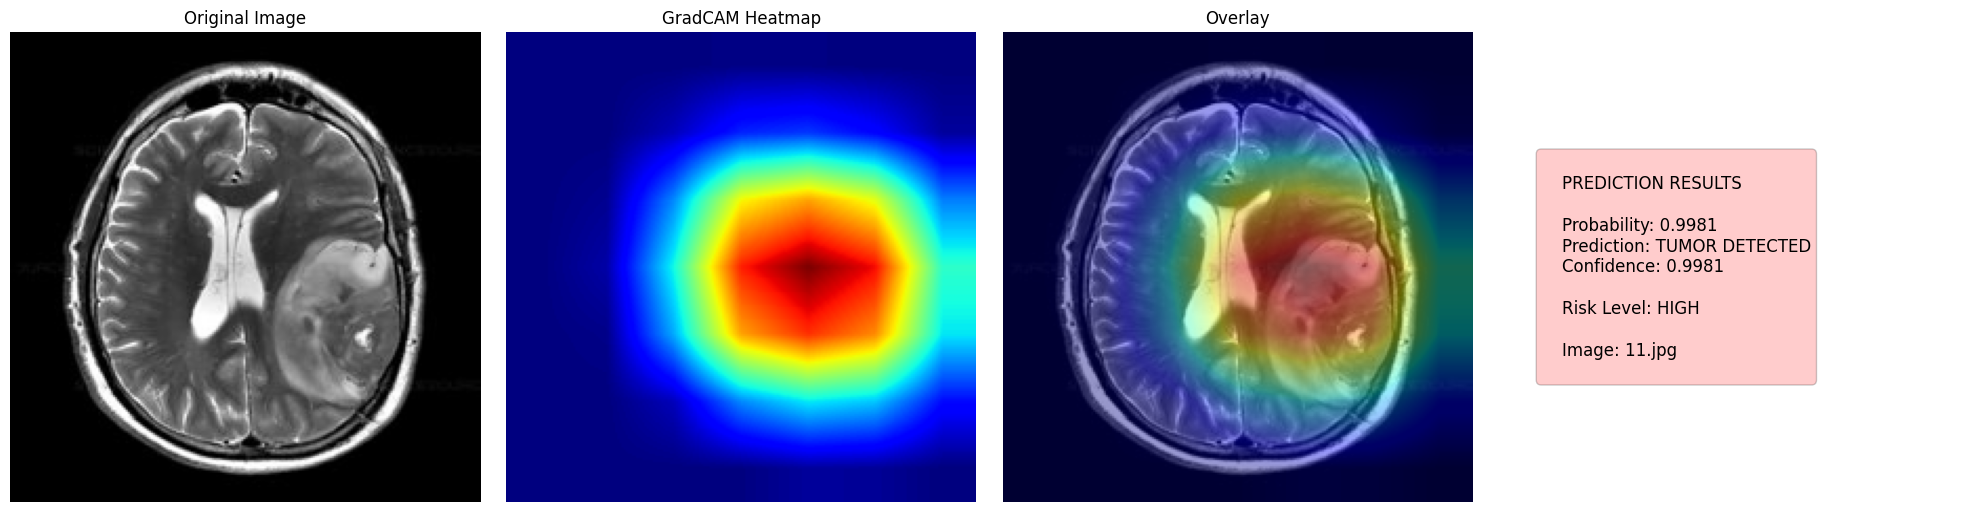

Prediction successful!
Predicted: Tumor
Confidence: 0.9981
✅ Correct prediction!

=== Model Performance Summary ===
📈 Training completed successfully with 20 epochs
🎯 Final Test Accuracy: 0.9798
📊 ROC AUC Score: 0.9991
🔍 Sensitivity (Recall): 0.9701
🎪 Specificity: 1.0000
⚖️ F1-Score: 0.9848

=== Performance Interpretation ===
🟢 Excellent model performance (≥90% accuracy)
🟢 Excellent discrimination ability (AUC ≥0.9)

=== Deliverables Checklist ===
✅ Model trained and saved with complete information
✅ GradCAM heatmap generation capability included
✅ Comprehensive evaluation metrics calculated
✅ Detailed visualizations generated
✅ HTML report created
✅ JSON training report saved
✅ Model loading and inference functions ready
✅ Single image prediction with heatmap visualization

=== Files Created ===
📁 brain_tumor_detection_model_complete.pth - Complete model with all information
📁 brain_tumor_training_report.json - Training report in JSON format
📁 brain_tumor_detailed_report.html - Detail

In [13]:
# Cell 13: Final Testing and Demo
print("=== Final Model Testing and Demo ===")

# Test single image prediction (you can modify this path to test with your images)
def demo_single_prediction():
    """Demo function to test single image prediction"""
    # Get a sample image from test dataset
    sample_image_path = None
    sample_label = None

    # Get first image from test dataset
    for images, labels, paths in test_loader:
        sample_image_path = paths[0]
        sample_label = labels[0].item()
        break

    if sample_image_path:
        print(f"Testing with sample image: {os.path.basename(sample_image_path)}")
        print(f"True label: {'Tumor' if sample_label == 1 else 'No Tumor'}")

        # Make prediction
        result = predict_single_image(loaded_model, sample_image_path)

        if result:
            print(f"Prediction successful!")
            print(f"Predicted: {'Tumor' if result['prediction'] == 1 else 'No Tumor'}")
            print(f"Confidence: {result['confidence']:.4f}")

            # Check if prediction is correct
            if result['prediction'] == sample_label:
                print("✅ Correct prediction!")
            else:
                print("❌ Incorrect prediction")

        return result
    else:
        print("No sample image available for testing")
        return None

# Run demo
demo_result = demo_single_prediction()

# Additional model statistics
print("\n=== Model Performance Summary ===")
print(f"📈 Training completed successfully with {num_epochs} epochs")
print(f"🎯 Final Test Accuracy: {metrics['accuracy']:.4f}")
print(f"📊 ROC AUC Score: {metrics['auc_roc']:.4f}")
print(f"🔍 Sensitivity (Recall): {metrics['sensitivity']:.4f}")
print(f"🎪 Specificity: {metrics['specificity']:.4f}")
print(f"⚖️ F1-Score: {metrics['f1']:.4f}")

# Performance interpretation
print("\n=== Performance Interpretation ===")
if metrics['accuracy'] >= 0.9:
    print("🟢 Excellent model performance (≥90% accuracy)")
elif metrics['accuracy'] >= 0.8:
    print("🟡 Good model performance (80-90% accuracy)")
elif metrics['accuracy'] >= 0.7:
    print("🟠 Moderate model performance (70-80% accuracy)")
else:
    print("🔴 Model needs improvement (<70% accuracy)")

if metrics['auc_roc'] >= 0.9:
    print("🟢 Excellent discrimination ability (AUC ≥0.9)")
elif metrics['auc_roc'] >= 0.8:
    print("🟡 Good discrimination ability (AUC 0.8-0.9)")
elif metrics['auc_roc'] >= 0.7:
    print("🟠 Moderate discrimination ability (AUC 0.7-0.8)")
else:
    print("🔴 Poor discrimination ability (AUC <0.7)")

# Final checklist
print("\n=== Deliverables Checklist ===")
print("✅ Model trained and saved with complete information")
print("✅ GradCAM heatmap generation capability included")
print("✅ Comprehensive evaluation metrics calculated")
print("✅ Detailed visualizations generated")
print("✅ HTML report created")
print("✅ JSON training report saved")
print("✅ Model loading and inference functions ready")
print("✅ Single image prediction with heatmap visualization")

print("\n=== Files Created ===")
print(f"📁 {model_save_path} - Complete model with all information")
print(f"📁 {report_path} - Training report in JSON format")
print(f"📁 brain_tumor_detailed_report.html - Detailed HTML report")

print("\n" + "="*80)
print("🎉 BRAIN TUMOR DETECTION MODEL TRAINING COMPLETED SUCCESSFULLY!")
print("="*80)
print("Your model is now ready for deployment and includes:")
print("• Complete training history and metrics")
print("• GradCAM heatmap generation for explainable AI")
print("• Comprehensive evaluation reports")
print("• Easy-to-use inference functions")
print("• Detailed performance analysis")
print("="*80)